In [1]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR

def rmse(pred, actual):
    return np.sqrt(((pred - actual) ** 2).mean())


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


In [4]:
# LOAD DATA

data_path = "../Year data P//"

df = pd.read_csv(data_path + 'Japan//Japan Data.csv')
df.head()


,countrycode,country,currency_unit,year,GDP,net population growth,CPI,employment rate,labsh,xr,...,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,GDP.1
0,JPN,Japan,Yen,1979,NaN,116.867400,NaN,0.505256,0.620528,219.1400,...,-0.136450,-0.002134,0.482394,0.375527,0.413489,0.374152,0.335963,0.336669,1.206380,NaN
1,JPN,Japan,Yen,1980,2.817592,0.008125,7.758333,-0.000985,0.000000,226.7408,...,-0.009820,-0.982586,0.019092,0.009485,0.001676,0.038754,0.214920,0.057992,-0.045856,2.817592
2,JPN,Japan,Yen,1981,4.176879,0.007774,4.941667,0.000419,-0.002118,220.5358,...,-0.008068,26.911396,0.096173,0.106764,0.099053,0.074735,0.030941,0.090274,-0.020976,4.176879
3,JPN,Japan,Yen,1982,3.376506,0.007348,2.750000,0.001303,0.004039,249.0767,...,-0.041710,-0.421139,-0.069843,-0.051039,-0.045599,-0.065368,-0.030639,-0.006193,-0.070059,3.376506
4,JPN,Japan,Yen,1983,3.060805,0.006875,1.900000,0.008201,0.003591,237.5117,...,-0.040567,0.948825,0.091115,0.160418,0.123268,0.021363,0.019456,0.165765,0.022857,3.060805


In [6]:
df = df.loc[df['YEAR'] >= 1980]
df = df.drop(['YEAR'],axis = 1)
year = pd.period_range('1980', '2021', freq='Y')
df.index = year

df = df.iloc[:,[0,1,2,3,4,5,6,8,0]]

KeyError: 'YEAR'

In [ ]:
df.tail()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Xscaler =MinMaxScaler()
df.iloc[:,0:-1]=Xscaler.fit_transform(df.values[:,0:-1])

In [ ]:
df_train = df['1980':'2009']
df_test = df['2010':'2019']

In [ ]:
for i in range(0,8):
    adfResult = sm.tsa.stattools.adfuller(df.iloc[:,i])
    if adfResult[1]<0.05:
        print(i)
        print(df.columns[i])
        print("stable")
    else:
        print(i)
        print(df.columns[i])
        print("UNstable")

In [ ]:
df.iloc[:,0] = df.iloc[:,0].diff(1)
df.iloc[:,2] = df.iloc[:,2].diff(1)
df.iloc[:,3] = df.iloc[:,3].diff(1)
df.iloc[:,6] = df.iloc[:,6].diff(1)
df.iloc[:,7] = df.iloc[:,7].diff(1)

df_train = df['1980':'2009']
df_test = df['2010':'2019']

In [ ]:
for i in range(0,8):
    adfResult = sm.tsa.stattools.adfuller(df.iloc[1:,i])
    if adfResult[1]<0.05:
        print(i)
        print(df.columns[i])
        print("stable")
    else:
        print(i)
        print(df.columns[i])
        print("UNstable")
    

In [ ]:
for i in range(0,8):
    result = sm.tsa.stattools.coint(df.iloc[1:,-1],df.iloc[1:,i])
    if result[1]<0.05:
        print(i)
        print(df.columns[i])
        print("coint")
    else:
        print(i)
        print(df.columns[i])
        print("not coint")

In [ ]:
df_train = df.iloc[1:,[0,1,2,3,4]]['1981':'2009']
df_test = df.iloc[1:,[0,1,2,3,4]]['2010':'2019']

In [ ]:
### FIND BEST VAR ORDER with AIC ###
AIC = {}
best_aic, best_order = np.inf, 0
lagsToTest = 4
for i in range(1, lagsToTest):
    model = VAR(df_train.values)
    model_result = model.fit(i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

In [ ]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###
var = VAR(df_train)
var_result = var.fit(maxlags=best_order)
print("var_result.aic: ", var_result.aic)

In [3]:
print(len(df_test.values[-best_order:]))

forecast_input = df_test.values[-best_order:]

# Forecast
fc = var_result.forecast(y = forecast_input, steps=5)
df_forecast = pd.DataFrame(fc, index=pd.period_range(start = '2020',end = '2024',freq = 'Y'), columns=df_test.columns)
#print(df_forecast)

NameError: name 'df_test' is not defined

<AxesSubplot:>

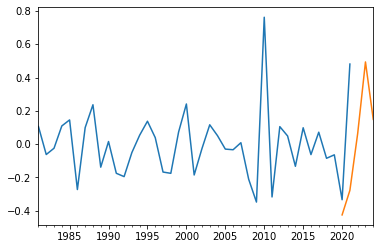

In [29]:
plt.figure()
df.iloc[1:,0].plot()
df_forecast.iloc[:,0].plot()

In [31]:
predict_Test = var_result.forecast(y = df_train.values, steps=10)
rmse(predict_Test[:,0],df_test.iloc[:,0].values)

0.36263425551876977

0.14024101201548403


<AxesSubplot:>

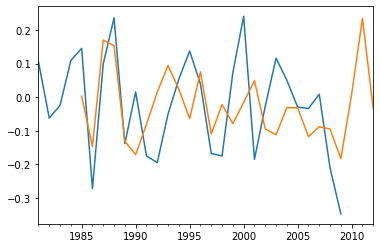

In [32]:
fitted_value = np.zeros((28,df_train.shape[1]))
for i in range(0,28,4):
    a = var_result.forecast(y = df_train.iloc[i:i+4,:].values, steps=4)
    fitted_value[i:i+4,:] = a

fitted_value = pd.DataFrame(fitted_value, index=pd.period_range(start = '1985',end = '2012',freq = 'Y'), columns=df_train.columns)
#print(df_forecast)

print(rmse(fitted_value.iloc[:-3,0],df_train.iloc[4:,0].values))
plt.figure()
df_train.iloc[:,0].plot()
fitted_value.iloc[:,0].plot()